CODIGO ORGANIZAITO

montamos librerias y el drive junto a la ruta del audio

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft, istft
from google.colab import drive

# 🔹 Montar Google Drive
drive.mount('/content/drive')

# 🔹 Ruta del archivo en Google Drive
audio_path = "/content/drive/MyDrive/Data_Augmentation/JUAN/AUDIO_DATA_AUGM/DATA/VNE_31_P2_42_BI.wav"

Mounted at /content/drive


carga un archivo de audio y extrae dos datos esenciales:
1. sample_rate (Frecuencia de muestreo): Número de muestras por segundo (medido en Hz).
2. audio (Señal de audio): Una matriz de valores numéricos que representan la forma de onda del sonido.
    * Si es mono: Una sola serie de valores.
    * Si es estéreo: Dos columnas (una para cada canal: izquierdo y derecho).

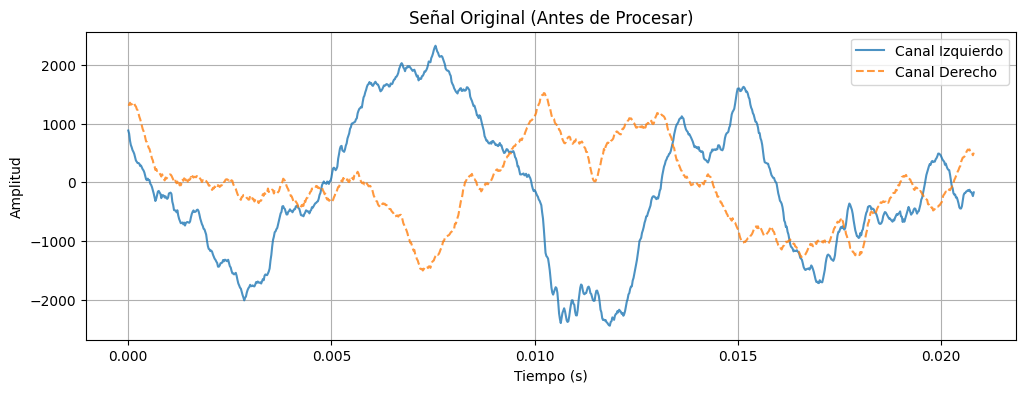

In [4]:
# 🔹 Cargar el archivo de audio
sample_rate, audio = wavfile.read(audio_path)

# 🔹 Verificar si el audio es estéreo o mono
is_stereo = len(audio.shape) > 1
if is_stereo:
    left_channel = audio[:, 0]  # Canal izquierdo
    right_channel = audio[:, 1]  # Canal derecho
else:
    left_channel = right_channel = audio  # Si es mono, tratamos ambos como el mismo

import matplotlib.pyplot as plt
import numpy as np

# Crear eje de tiempo
time_original = np.linspace(0, len(left_channel) / sample_rate, num=len(left_channel))

# 🔹 Gráfica de la señal original
plt.figure(figsize=(12, 4))
plt.plot(time_original[:1000], left_channel[:1000], label="Canal Izquierdo", alpha=0.8)
plt.plot(time_original[:1000], right_channel[:1000], label="Canal Derecho", linestyle="dashed", alpha=0.8)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal Original (Antes de Procesar)")
plt.legend()
plt.grid(True)
plt.show()

* Con el objetivo de lograr un Pitch Shift suave y natural se hace una validacion e interpolacion de los puntos.

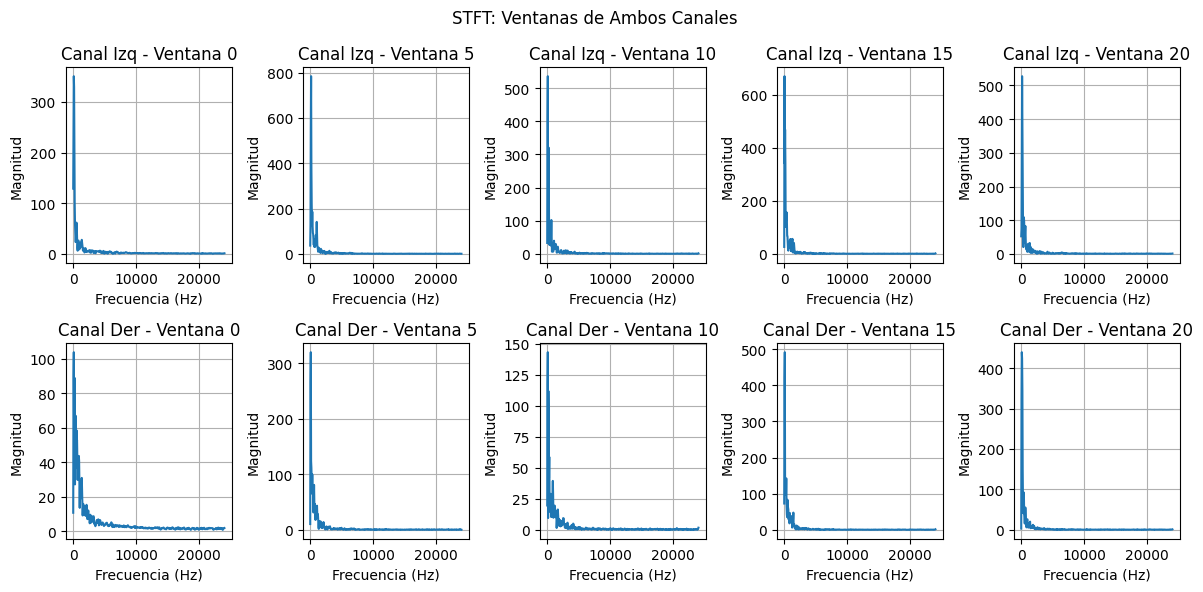

In [6]:
# 🔹 Función para aplicar Pitch Shift usando Phase Vocoder a un solo canal
def pitch_shift(audio, sample_rate, semitones):
    factor = 2 ** (semitones / 12)  # Factor de cambio de tono
    window_size = 1024
    hop_size = window_size // 4

    # Calcular la STFT
    f, t, Zxx = stft(audio, fs=sample_rate, nperseg=window_size, noverlap=hop_size)

    # Validación para evitar división por cero
    if np.max(np.abs(Zxx)) == np.min(np.abs(Zxx)):
        print("⚠️ La STFT tiene valores uniformes, posible error en la señal.")
        return audio

    # Ajustar la frecuencia multiplicando por el factor de cambio de tono
    new_f = f * factor

    # Inicialización de variables para el Phase Vocoder
    phase = np.angle(Zxx)
    last_phase = np.angle(Zxx)
    time_stretch = int(len(t) * factor)

    # Interpolación correcta con ajuste de fase
    shifted_Zxx = np.zeros((len(f), time_stretch), dtype=np.complex_)
    for i in range(1, time_stretch):
        index = int(i / factor)
        left = int(np.floor(index))
        right = min(left + 1, len(t) - 1)

        left_weight = right - index
        right_weight = 1 - left_weight

        mag = left_weight * np.abs(Zxx[:, left]) + right_weight * np.abs(Zxx[:, right])

        delta_phase = (np.angle(Zxx[:, right]) - np.angle(Zxx[:, left])) - 2 * np.pi * (right - left) * hop_size / window_size
        delta_phase = np.mod(delta_phase + np.pi, 2 * np.pi) - np.pi

        phase[:, i] = phase[:, i-1] + delta_phase
        shifted_Zxx[:, i] = mag * np.exp(1j * phase[:, i])

      # Reconstrucción de la señal con la iSTFT
    _, shifted_audio = istft(shifted_Zxx, fs=sample_rate, nperseg=window_size, noverlap=hop_size)

    return shifted_audio.astype(np.int16)

import matplotlib.pyplot as plt
import numpy as np

# Calcular la STFT de ambos canales
f_left, t_left, Zxx_left = stft(left_channel, fs=sample_rate, nperseg=1024, noverlap=256)
f_right, t_right, Zxx_right = stft(right_channel, fs=sample_rate, nperseg=1024, noverlap=256)

# Seleccionar algunas ventanas (ejemplo: 5 primeras)
ventanas = [0, 5, 10, 15, 20]

plt.figure(figsize=(12, 6))

for i, v in enumerate(ventanas):
    plt.subplot(2, len(ventanas), i+1)
    plt.plot(f_left, np.abs(Zxx_left[:, v]))
    plt.title(f"Canal Izq - Ventana {v}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.grid(True)

    plt.subplot(2, len(ventanas), i+1+len(ventanas))
    plt.plot(f_right, np.abs(Zxx_right[:, v]))
    plt.title(f"Canal Der - Ventana {v}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.grid(True)

plt.suptitle("STFT: Ventanas de Ambos Canales")
plt.tight_layout()
plt.show()

hacemos uso de la funcion anterior que aplica pitch shift a un canal por lo que creamos una la varible Shifted_Left y Shifted_Right donde se calcula cada canal por separado.

en caso de que alguno de los canales termine durando un poco mas o un poco menos se calcula cual es el de menor duracion y se recorta el otro para garantizar que no hayan fallos por longitud.

se combinan ambos canales en una sola señal
Usa np.column_stack() para apilar columnas.
El resultado es un array
de forma [n_muestras, 2] (izquierdo, derecho).

por ultimo guardamos el archivo en el drive.

In [ ]:
# 🔹 Aplicar Pitch Shift a cada canal por separado (+3 semitonos)
shifted_left = pitch_shift(left_channel, sample_rate, semitones=3)
shifted_right = pitch_shift(right_channel, sample_rate, semitones=3)

# 🔹 Ajustar tamaños si hay desajuste de longitud
min_length = min(len(shifted_left), len(shifted_right))
shifted_left, shifted_right = shifted_left[:min_length], shifted_right[:min_length]

# 🔹 Combinar ambos canales en una señal estéreo
shifted_audio_stereo = np.column_stack((shifted_left, shifted_right))

# 🔹 Guardar el archivo modificado en Google Drive
output_path = "/content/drive/MyDrive/Data_Augmentation/JUAN/AUDIO_DATA_AUGM/AudioPuro/pp_pitch_shift_stereo.wav"
wavfile.write(output_path, sample_rate, shifted_audio_stereo)

GRAFICAMOSSS!! hermosas graficas graficas hermosas uwu

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from google.colab import drive
import os
# 🔹 PLOTEAR GRÁFICAS CON ETIQUETAS

# 1️⃣ Señales en el dominio del tiempo
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

#✅ ¿Qué hace?:
#plt.figure() crea una ventana para la gráfica.
#figsize=(12, 4) ajusta el tamaño (12 pulgadas de ancho y 4 pulgadas de alto)✅.

time_original = np.linspace(0, len(left_channel) / sample_rate, num=len(left_channel))
time_shifted = np.linspace(0, len(shifted_left) / sample_rate, num=len(shifted_left))

#✅ Usa np.linspace() para crear una línea de tiempo desde 0 segundos hasta la duración total del audio
# duracion (s) = numero de muestras/frecuencia de muestreo ✅.

axs[0].plot(time_original[:1000], left_channel[:1000], label="Canal Izquierdo Original")
axs[0].plot(time_shifted[:1000], shifted_left[:1000], label="Canal Izquierdo Pitch Shifted", linestyle="dashed")
axs[0].set_ylabel("Amplitud")
axs[0].set_title("Comparación del Canal Izquierdo en el Dominio del Tiempo")
axs[0].legend()
axs[0].grid()

axs[1].plot(time_original[:1000], right_channel[:1000], label="Canal Derecho Original")
axs[1].plot(time_shifted[:1000], shifted_right[:1000], label="Canal Derecho Pitch Shifted", linestyle="dashed")
axs[1].set_xlabel("Tiempo (s)")
axs[1].set_ylabel("Amplitud")
axs[1].set_title("Comparación del Canal Derecho en el Dominio del Tiempo")
axs[1].legend()
axs[1].grid()

plt.show()

# 2️⃣ Espectrograma de la señal original
plt.figure(figsize=(12, 5))
f, t, Zxx = stft(left_channel, fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')  # log1p mejora la visualización
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma del Canal Izquierdo Original")
plt.colorbar(label="Magnitud")
plt.show()

# 3️⃣ Espectrograma del Canal Izquierdo con Pitch Shift
plt.figure(figsize=(12, 5))
f, t, Zxx = stft(shifted_left, fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma del Canal Izquierdo Pitch Shifted")
plt.colorbar(label="Magnitud")
plt.show()

plt.figure(figsize=(12, 5))
f, t, Zxx = stft(right_channel, fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma del Canal Derecho Original")
plt.colorbar(label="Magnitud")
plt.show()

# 4️⃣ Espectrograma del Canal Derecho con Pitch Shift
plt.figure(figsize=(12, 5))
f, t, Zxx = stft(shifted_right, fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma del Canal Derecho Pitch Shifted")
plt.colorbar(label="Magnitud")
plt.show()

##

plt.figure(figsize=(12, 5))
f, t, Zxx = stft(np.mean([left_channel, right_channel], axis=0), fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma Completo - Ambos Canales Originales")
plt.colorbar(label="Magnitud")
plt.show()
# Crear eje de tiempo
time_original = np.linspace(0, len(left_channel) / sample_rate, num=len(left_channel))

plt.figure(figsize=(12, 5))
f, t, Zxx = stft(np.mean([shifted_left, shifted_right], axis=0), fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma Completo - Ambos Canales Pitch Shifted")
plt.colorbar(label="Magnitud")
plt.show()

# 🔹 Gráfica de la señal original con ambos canales
plt.figure(figsize=(12, 4))

# Graficar los dos canales
plt.plot(time_original[:1000], left_channel[:1000], label="Canal Izquierdo Original", alpha=0.8)
plt.plot(time_original[:1000], right_channel[:1000], label="Canal Derecho Original", linestyle="dashed", alpha=0.8)

#✅ ¿Qué hace?:
# Usa plt.plot() para dibujar las formas de onda.
# time_original[:1000]: Solo muestra los primeros 1000 puntos para no saturar la gráfica.
# label="...": Pone nombres a las líneas.
# alpha=0.8: Hace las líneas ligeramente transparentes para ver mejor la superposición.
# El Canal Derecho aparece como línea punteada (linestyle="dashed") para distinguirlos✅.

# Etiquetas y formato
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal Estéreo Original (Antes de Pitch Shift)")
plt.legend()
plt.grid()
plt.show()

# 5️⃣ Señal estéreo combinada en el dominio del tiempo
plt.figure(figsize=(12, 4))
plt.plot(time_shifted[:1000], shifted_left[:1000], label="Canal Izquierdo Pitch Shifted")
plt.plot(time_shifted[:1000], shifted_right[:1000], label="Canal Derecho Pitch Shifted", linestyle="dashed")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal Estéreo Final (Ambos Canales Combinados)")
plt.legend()
plt.grid()
plt.show()

# 🔹 Mostrar información final
print(f"✅ Archivo estéreo modificado guardado en: {output_path}")
print("🔍 Primeros 20 valores después de la transformación (Canal Izquierdo):", shifted_left[:20])
print("🔍 Primeros 20 valores después de la transformación (Canal Derecho):", shifted_right[:20])


# 📊 Generar PDF con Plots de Audio en Google Drive

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import stft
from matplotlib.backends.backend_pdf import PdfPages

# 📂 Ruta de guardado en Google Drive
output_path = "/content/drive/MyDrive/Data_Augmentation/JUAN/AUDIO_DATA_AUGM/pdf/Resultados_Pitch_Shiftedd.pdf"

# 📘 Crear archivo PDF
with PdfPages(output_path) as pdf:

    # 1️⃣ Señales en el dominio del tiempo
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    axs[0].plot(time_original[:1000], left_channel[:1000], label="Canal Izquierdo Original")
    axs[0].plot(time_shifted[:1000], shifted_left[:1000], label="Canal Izquierdo Pitch Shifted", linestyle="dashed")
    axs[0].set_ylabel("Amplitud")
    axs[0].set_title("Comparación del Canal Izquierdo en el Dominio del Tiempo")
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(time_original[:1000], right_channel[:1000], label="Canal Derecho Original")
    axs[1].plot(time_shifted[:1000], shifted_right[:1000], label="Canal Derecho Pitch Shifted", linestyle="dashed")
    axs[1].set_xlabel("Tiempo (s)")
    axs[1].set_ylabel("Amplitud")
    axs[1].set_title("Comparación del Canal Derecho en el Dominio del Tiempo")
    axs[1].legend()
    axs[1].grid()
    pdf.savefig(fig)
    plt.close(fig)

    # 2️⃣ Espectrogramas de ambos canales
    for channel, signal, title in [("Izquierdo", left_channel, "Original"), ("Derecho", right_channel, "Original"),
                                   ("Izquierdo", shifted_left, "Pitch Shifted"), ("Derecho", shifted_right, "Pitch Shifted")]:
        fig = plt.figure(figsize=(12, 5))
        f, t, Zxx = stft(signal, fs=sample_rate, nperseg=1024, noverlap=256)
        plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Frecuencia (Hz)")
        plt.title(f"Espectrograma del Canal {channel} {title}")
        plt.colorbar(label="Magnitud")
        pdf.savefig(fig)
        plt.close(fig)

    # 3️⃣ Señal estéreo original (Antes de Pitch Shift)
    fig = plt.figure(figsize=(12, 4))
    plt.plot(time_original[:1000], left_channel[:1000], label="Canal Izquierdo Original", alpha=0.8)
    plt.plot(time_original[:1000], right_channel[:1000], label="Canal Derecho Original", linestyle="dashed", alpha=0.8)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.title("Señal Estéreo Original (Antes de Pitch Shift)")
    plt.legend()
    plt.grid()
    pdf.savefig(fig)
    plt.close(fig)

    # 4️⃣ Señal estéreo combinada (Ambos Canales Pitch Shifted)
    fig = plt.figure(figsize=(12, 4))
    plt.plot(time_shifted[:1000], shifted_left[:1000], label="Canal Izquierdo Pitch Shifted")
    plt.plot(time_shifted[:1000], shifted_right[:1000], label="Canal Derecho Pitch Shifted", linestyle="dashed")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.title("Señal Estéreo Final (Ambos Canales Combinados)")
    plt.legend()
    plt.grid()
    pdf.savefig(fig)
    plt.close(fig)

    print(f"✅ PDF generado exitosamente en: {output_path}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from google.colab import drive
import os
# 🔹 PLOTEAR GRÁFICAS CON ETIQUETAS

# 1️⃣ Señales en el dominio del tiempo
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

#✅ ¿Qué hace?:
#plt.figure() crea una ventana para la gráfica.
#figsize=(12, 4) ajusta el tamaño (12 pulgadas de ancho y 4 pulgadas de alto)✅.

time_original = np.linspace(0, len(left_channel) / sample_rate, num=len(left_channel))
time_shifted = np.linspace(0, len(shifted_left) / sample_rate, num=len(shifted_left))

#✅ Usa np.linspace() para crear una línea de tiempo desde 0 segundos hasta la duración total del audio
# duracion (s) = numero de muestras/frecuencia de muestreo ✅.

axs[0].plot(time_original[:1000], left_channel[:1000], label="Canal Izquierdo Original")
axs[0].plot(time_shifted[:1000], shifted_left[:1000], label="Canal Izquierdo Pitch Shifted", linestyle="dashed")
axs[0].set_ylabel("Amplitud")
axs[0].set_title("Comparación del Canal Izquierdo en el Dominio del Tiempo")
axs[0].legend()
axs[0].grid()

axs[1].plot(time_original[:1000], right_channel[:1000], label="Canal Derecho Original")
axs[1].plot(time_shifted[:1000], shifted_right[:1000], label="Canal Derecho Pitch Shifted", linestyle="dashed")
axs[1].set_xlabel("Tiempo (s)")
axs[1].set_ylabel("Amplitud")
axs[1].set_title("Comparación del Canal Derecho en el Dominio del Tiempo")
axs[1].legend()
axs[1].grid()

plt.show()

# 2️⃣ Espectrograma de la señal original
plt.figure(figsize=(12, 5))
f, t, Zxx = stft(left_channel, fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')  # log1p mejora la visualización
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma del Canal Izquierdo Original")
plt.colorbar(label="Magnitud")
plt.show()

# 3️⃣ Espectrograma del Canal Izquierdo con Pitch Shift
plt.figure(figsize=(12, 5))
f, t, Zxx = stft(shifted_left, fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma del Canal Izquierdo Pitch Shifted")
plt.colorbar(label="Magnitud")
plt.show()

plt.figure(figsize=(12, 5))
f, t, Zxx = stft(right_channel, fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma del Canal Derecho Original")
plt.colorbar(label="Magnitud")
plt.show()

# 4️⃣ Espectrograma del Canal Derecho con Pitch Shift
plt.figure(figsize=(12, 5))
f, t, Zxx = stft(shifted_right, fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma del Canal Derecho Pitch Shifted")
plt.colorbar(label="Magnitud")
plt.show()

##

plt.figure(figsize=(12, 5))
f, t, Zxx = stft(np.mean([left_channel, right_channel], axis=0), fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma Completo - Ambos Canales Originales")
plt.colorbar(label="Magnitud")
plt.show()
# Crear eje de tiempo
time_original = np.linspace(0, len(left_channel) / sample_rate, num=len(left_channel))

plt.figure(figsize=(12, 5))
f, t, Zxx = stft(np.mean([shifted_left, shifted_right], axis=0), fs=sample_rate, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, np.log1p(np.abs(Zxx)), shading='gouraud')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.title("Espectrograma Completo - Ambos Canales Pitch Shifted")
plt.colorbar(label="Magnitud")
plt.show()

# 🔹 Gráfica de la señal original con ambos canales
plt.figure(figsize=(12, 4))

# Graficar los dos canales
plt.plot(time_original[:1000], left_channel[:1000], label="Canal Izquierdo Original", alpha=0.8)
plt.plot(time_original[:1000], right_channel[:1000], label="Canal Derecho Original", linestyle="dashed", alpha=0.8)

#✅ ¿Qué hace?:
# Usa plt.plot() para dibujar las formas de onda.
# time_original[:1000]: Solo muestra los primeros 1000 puntos para no saturar la gráfica.
# label="...": Pone nombres a las líneas.
# alpha=0.8: Hace las líneas ligeramente transparentes para ver mejor la superposición.
# El Canal Derecho aparece como línea punteada (linestyle="dashed") para distinguirlos✅.

# Etiquetas y formato
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal Estéreo Original (Antes de Pitch Shift)")
plt.legend()
plt.grid()
plt.show()

# 5️⃣ Señal estéreo combinada en el dominio del tiempo
plt.figure(figsize=(12, 4))
plt.plot(time_shifted[:1000], shifted_left[:1000], label="Canal Izquierdo Pitch Shifted")
plt.plot(time_shifted[:1000], shifted_right[:1000], label="Canal Derecho Pitch Shifted", linestyle="dashed")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal Estéreo Final (Ambos Canales Combinados)")
plt.legend()
plt.grid()
plt.show()

Output hidden; open in https://colab.research.google.com to view.